In [29]:
import magpylib as magpy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


def method_1(radius, distance, current):
    #distance = radius  # distance between the centers of the loops

    # Create the two circular loops
    loop1 = magpy.current.Circle(current=+current, diameter=2*radius)
    loop2 = magpy.current.Circle(current=-current, diameter=2*radius)

    # Position the loops at +distance/2 and -distance/2 along the z-axis
    loop1.move([0, 0, distance/2])
    loop2.move([0, 0, -distance/2])

    # Create a collection of the two loops
    collection = magpy.Collection(loop1, loop2)
    #collection.show()

    return collection

def method_1_windings(radius, distance, current, number_of_turns, wire_section):
    Print('WAIT CORRECT DISTANCE')
    distance = radius  # distance between the centers of the loops
    coil_thickness = number_of_turns*wire_section

    # Create the two coils 
    coil1 = magpy.Collection()
    coil2 = magpy.Collection()
    for z in np.linspace(-coil_thickness/2, coil_thickness/2, number_of_turns):
        winding = magpy.current.Circle(
        current=current,
        diameter=radius*2,
        position=(0,0,z-distance/2),
        )
        coil1.add(winding)

    for z in np.linspace(-coil_thickness/2, coil_thickness/2, number_of_turns):
        winding = magpy.current.Circle(
        current=-current,
        diameter=radius*2,
        position=(0,0,z+distance/2),
        )
        coil2.add(winding)
    
    # Create a collection of the two coils
    anti_helmholtz = magpy.Collection(coil1, coil2)

    # Position the loops at +distance/2 and -distance/2 along the z-axis
    #loop1.move([0, 0, distance/2])
    #loop2.move([0, 0, -distance/2])

    anti_helmholtz.show()

    return anti_helmholtz

def power(radius, current, number_of_turns,wire_radius):
    perimeter=2*np.pi*radius
    length=number_of_turns*perimeter
    surface_wire_section = np.pi*wire_radius*wire_radius
    ro=1.7*1e-8 # ohm*m
    resistance=ro*length/surface_wire_section
    power=resistance*current*current
    return power

#            # Sr parameters
#            radius = 70e-3  # in mm
#            distance_between_coils = 60e-3
#            number_of_turns = 12
#           current = 200*number_of_turns # in A
#             wire_section = 1.7e-3 # in mm
# 
#             # SrCu parameters
#             radius = 70e-3  # in mm
#             distance_between_coils = 200e-3
#            number_of_turns = 12
#            current = 200*number_of_turns # in A
#            wire_section = 1.7e-3 # in mm
#
#            #Define parameters
#            radius = 300e-3  # in mm
#            distance_between_coils = 400e-3
#            number_of_turns = 40
#            current = 123*number_of_turns # in A
#            wire_section = 1.7e-3 # in mm

# SrCu parameters
radius = 110e-3/2  # in mm
distance_between_coils = 165e-3
number_of_turns = 8.7
current = 122*number_of_turns # in A
wire_section = 1.25e-3 # in mm
# USEFUL FOR 3D CALCULATIONS
anti_helmholtz = method_1(radius, distance_between_coils, current)

# USE THIS ONE ONLY WITH 1D CALCULATIONS
#anti_helmholtz = method_1_windings(radius, current, number_of_turns, wire_section)
power_to_cool = power(radius, number_of_turns,current, wire_section /2 ) 
print('power to cool=', power_to_cool) 


power to cool= 384.5910385151998


(50, 50, 50)
-5.163925215966084  G/cm
-5.163925215966084  G/cm
10.542914902940478  G/cm
gradient calculé = 10.419998547451852


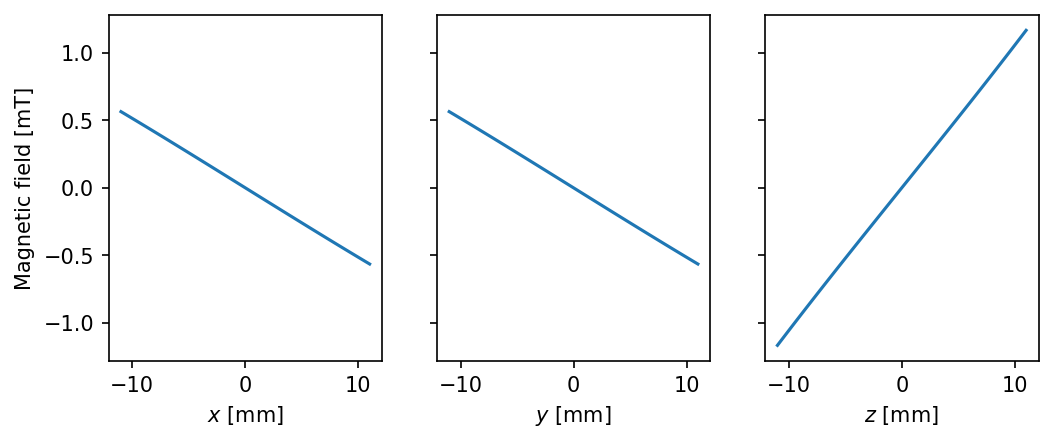

<Figure size 1200x900 with 0 Axes>

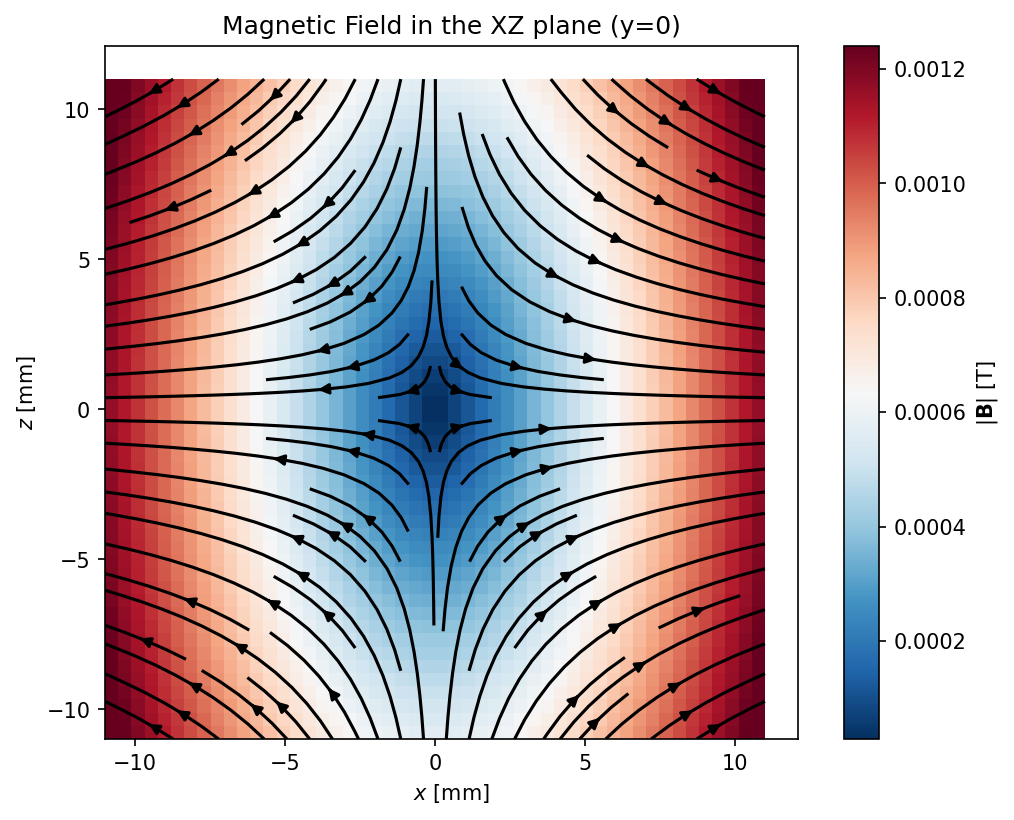

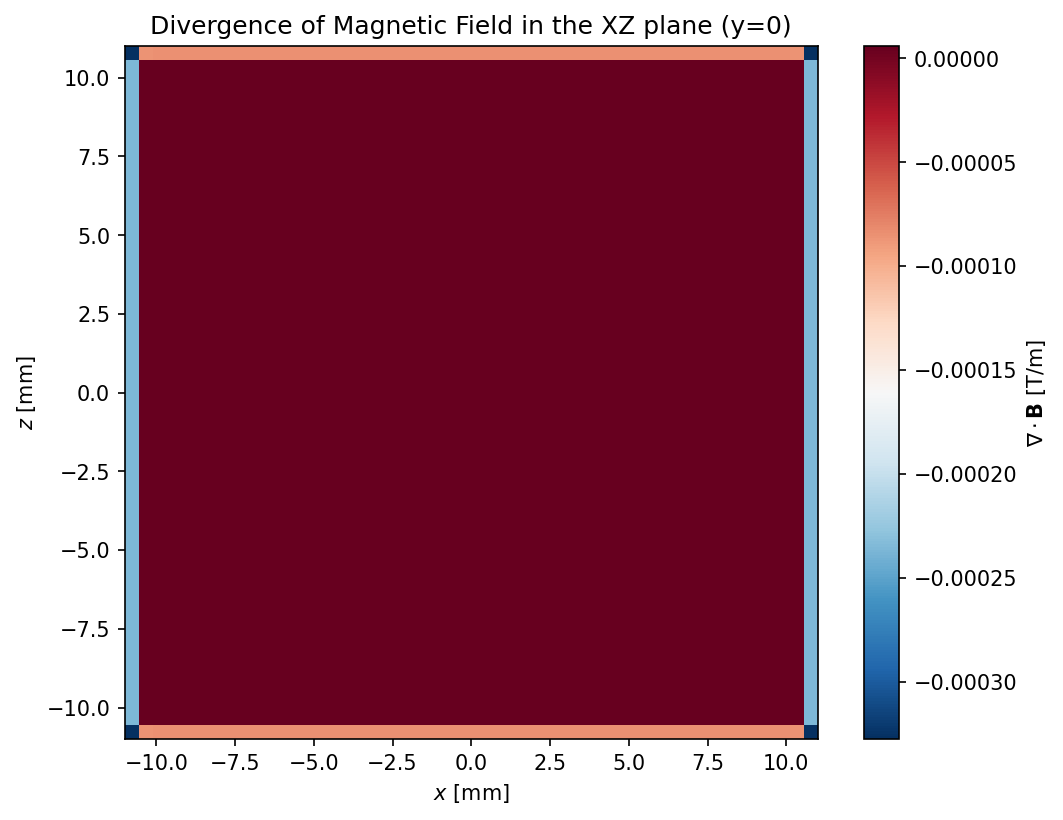

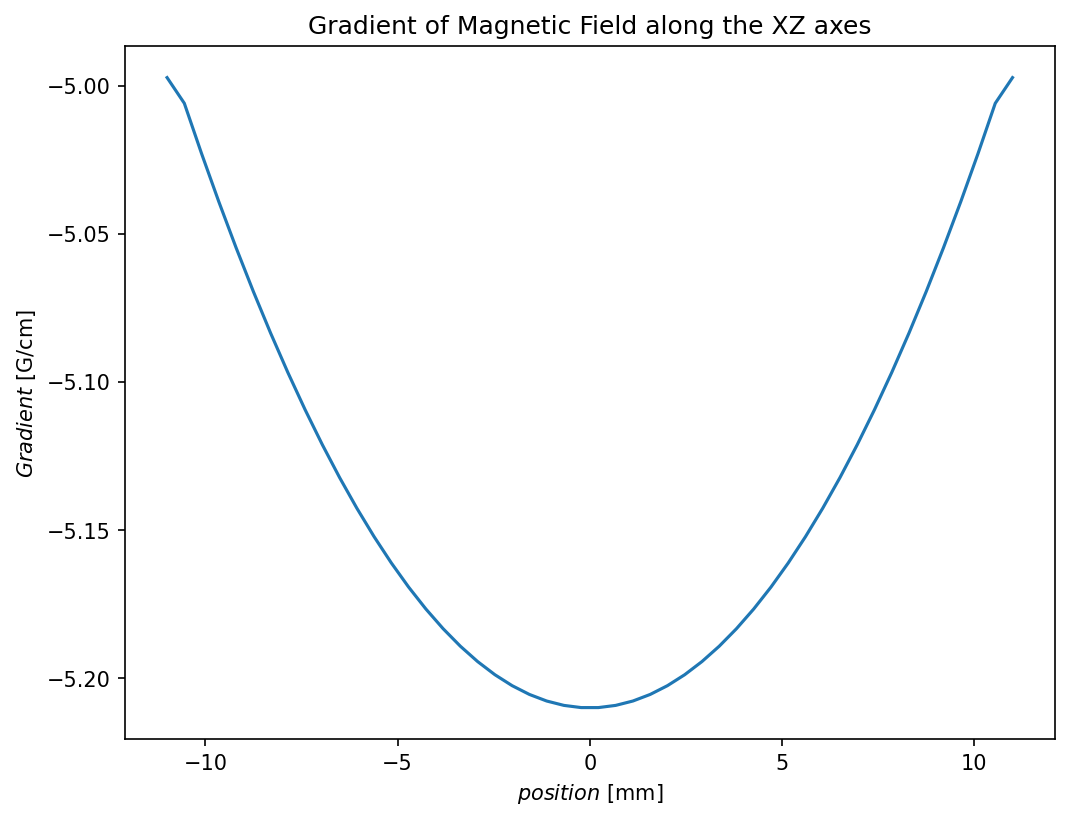

In [30]:

N = 50  # Increased grid resolution
r = np.linspace(-radius/10 * 2, radius/10 * 2, N)

# Define a 3D grid for calculation
mid = N//2 
dr = r[1]-r[0]

X_3D, Y_3D, Z_3D = np.meshgrid(r, r, r, indexing='ij')

# Flatten the grid for magpy.getB function
positions = np.vstack([X_3D.ravel(), Y_3D.ravel(), Z_3D.ravel()]).T

# Calculate the magnetic field components at each grid point
B = magpy.getB(anti_helmholtz, positions)

Bx = B[:, 0].reshape(N, N, N)
By = B[:, 1].reshape(N, N, N)
Bz = B[:, 2].reshape(N, N, N)

B = B.reshape((N, N, N, 3))
 
# Calculate the gradient
grad_Bx, grad_By, grad_Bz = np.gradient(Bx, dr, axis=0) , np.gradient(By, dr, axis=1) , np.gradient(Bz, dr, axis=2)
print(grad_Bx.shape)

# Calculate the numerical divergence of the magnetic field
div_B = grad_Bx +  grad_By +  grad_Bz 

# Magnetic field in the center
f, axs = plt.subplots(1,3, sharey=True, dpi=150,figsize=(8, 3))
from scipy.optimize import curve_fit

line = lambda x, a,b: a*x+b
popt, _ = curve_fit(line, r, Bx[:,mid,mid])
print(popt[0]*1e2, " G/cm")

popt, _ = curve_fit(line, r, By[mid,:,mid])
print(popt[0]*1e2, " G/cm")

popt, _ = curve_fit(line, r,  Bz[mid,mid,:])
print(popt[0]*1e2, " G/cm")
axs[0].plot(r*1e3, Bx[:,mid,mid]*1e3)
axs[1].plot(r*1e3, By[mid,:,mid]*1e3)
axs[2].plot(r*1e3, Bz[mid,mid,:]*1e3)
axs[0].set_xlabel('$x$ [mm]')
axs[1].set_xlabel('$y$ [mm]')
axs[2].set_xlabel('$z$ [mm]')
axs[0].set_ylabel('Magnetic field [mT]')

# Plot magnetic field
plt.figure(figsize=(8, 6), dpi=150)
X_2D, Z_2D = np.meshgrid(r, r, indexing='ij')

# Calculate the magnitude of the magnetic field in the XZ plane at Y=0 (midplane)
B_magnitude = np.sqrt(Bx[:, mid, :]**2 + By[:, mid, :]**2 + Bz[:, mid, :]**2)

# Clip the magnitude to a maximum value to avoid saturation
max_magnitude = np.percentile(B_magnitude, 99)  # Clipping at the 99th percentile
B_magnitude_clipped = np.clip(B_magnitude, None, max_magnitude)

B_grad_XZ_z = np.gradient(B_magnitude, axis=1)
B_grad_XZ_x = np.gradient(B_magnitude, axis=0)
B_grad_XY_mag = np.sqrt(B_grad_XZ_z**2 +B_grad_XZ_x**2 )
# Plot the magnitude of the magnetic field using imshow
img_borders = (r.min()*1e3, r.max()*1e3, r.min()*1e3, r.max()*1e3)
plt.figure(figsize=(8, 6), dpi=150)
plt.imshow(B_magnitude_clipped, extent=img_borders, origin='lower', cmap='RdBu_r')
plt.colorbar(label=r'$|\mathbf{B}|$ [T]')
plt.streamplot(Z_2D*1e3, X_2D*1e3,  Bz[:,mid,:],  Bx[:,mid,:], color="black", density=1 )
plt.title('Magnetic Field in the XZ plane (y=0)')
plt.xlabel('$x$ [mm]')
plt.ylabel('$z$ [mm]')
plt.gca().set_aspect("equal")

# Plot the divergence
plt.figure(figsize=(8, 6), dpi=150)
plt.imshow(div_B[:, mid, :], extent=img_borders, origin='lower', cmap='RdBu_r')
plt.colorbar(label='$\\nabla \\cdot \\mathbf{B}$ [T/m]')
plt.title('Divergence of Magnetic Field in the XZ plane (y=0)')
plt.xlabel('$x$ [mm]')
plt.ylabel('$z$ [mm]')

# Plot the gradient
plt.figure(figsize=(8, 6), dpi=150)
plt.title('Gradient of Magnetic Field along the XZ axes')
# plt.imshow(B_grad_XY_mag, extent=img_borders, origin='lower', cmap='RdBu_r')

#plt.plot(r*1e3, B_grad_XZ_z[:,mid]*1e4*1e-2)
#plt.plot(r*1e3, B_grad_XZ_x[mid,:]*1e4*1e-2)
plt.plot(r*1e3, grad_Bx[:,mid,mid]*1e4*1e-2)
#plt.plot(r*1e3, grad_Bz*1e4*1e-2)
plt.xlabel('$position$ [mm]')
plt.ylabel('$Gradient$ [G/cm]')

mu_0=1.256637*1e-6 #Newton.Ampere-2
gradient_calcule=(1e4/1e2)*(3*mu_0*current*radius*radius*distance_between_coils/2)/(radius*radius+(distance_between_coils/2)**2)**(5/2)
print('gradient calculé =',gradient_calcule)


# Find an Optimum

Number of Turns: 100%|██████████| 2/2 [00:00<00:00, 808.54it/s]


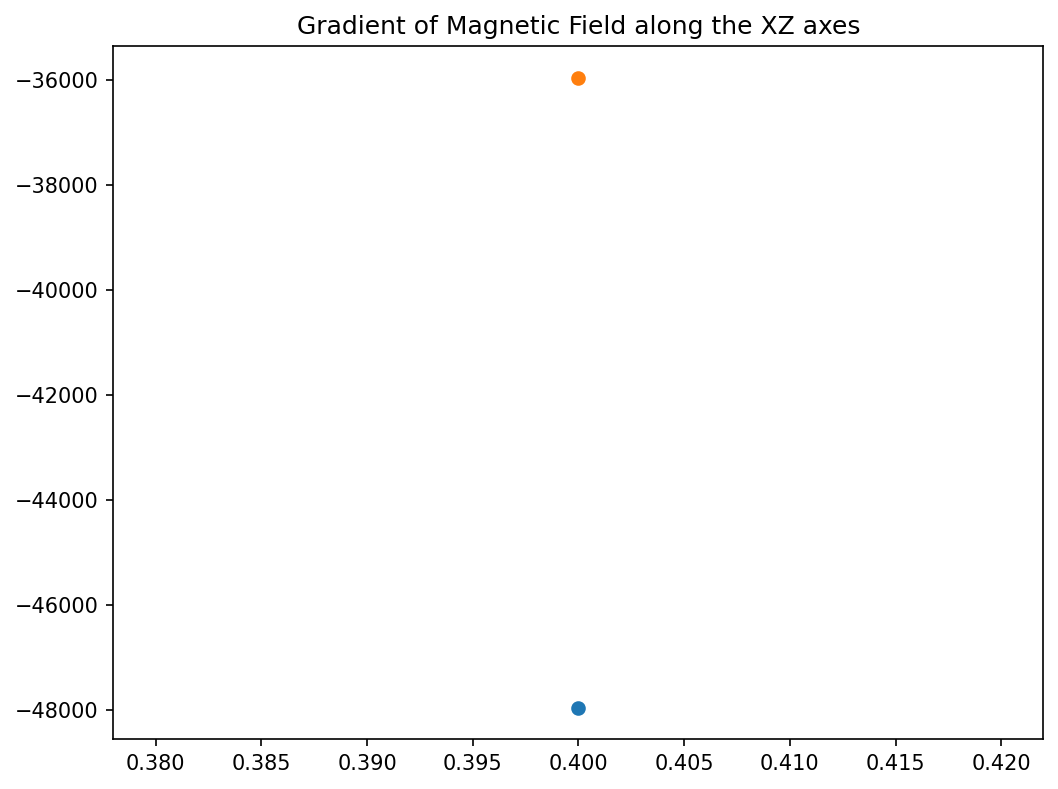

In [29]:
# Define parameters
distance_between_coils = 400e-3
radius =  np.arange(100e-3, 400e-3, 100e-3)  # in mm
number_of_turns = np.arange(150,250,50)
#current = [200*number_of_turns,300*number_of_turns,400*number_of_turns,500*number_of_turns] # in A
current = np.arange(5,15,1) # in A
wire_section = [0.5e-3,1e-3,2e-3] # in mm

#Creat the plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.set_title('Gradient of Magnetic Field along the XZ axes')
#ax.set_xlabel('$position$ [mm]')
#ax.set_ylabel('$Gradient$ [G/cm]')
mu_0=1.256637*1e-6 #Newton.Ampere-2

def current_func(R_bob, N, distance_between_coils=400e-3):
    return -((30*1-4*1e-2)*((R_bob*R_bob+distance_between_coils*distance_between_coils)**(5/2))/(3*mu_0*R_bob*R_bob*distance_between_coils))/N



for i, N in enumerate(tqdm(number_of_turns, desc="Number of Turns")):
    for R_bob in radius:
        I=-((30*1-4*1e-2)*((R_bob*R_bob+distance_between_coils*distance_between_coils)**(5/2))/(3*mu_0*R_bob*R_bob*distance_between_coils))/N
    ax.plot(R_bob, I,'o',color=f"C{i}")
        
        


#power_to_cool = power(radius, number_of_turns,current ) 
#print('power to cool=', power_to_cool) 

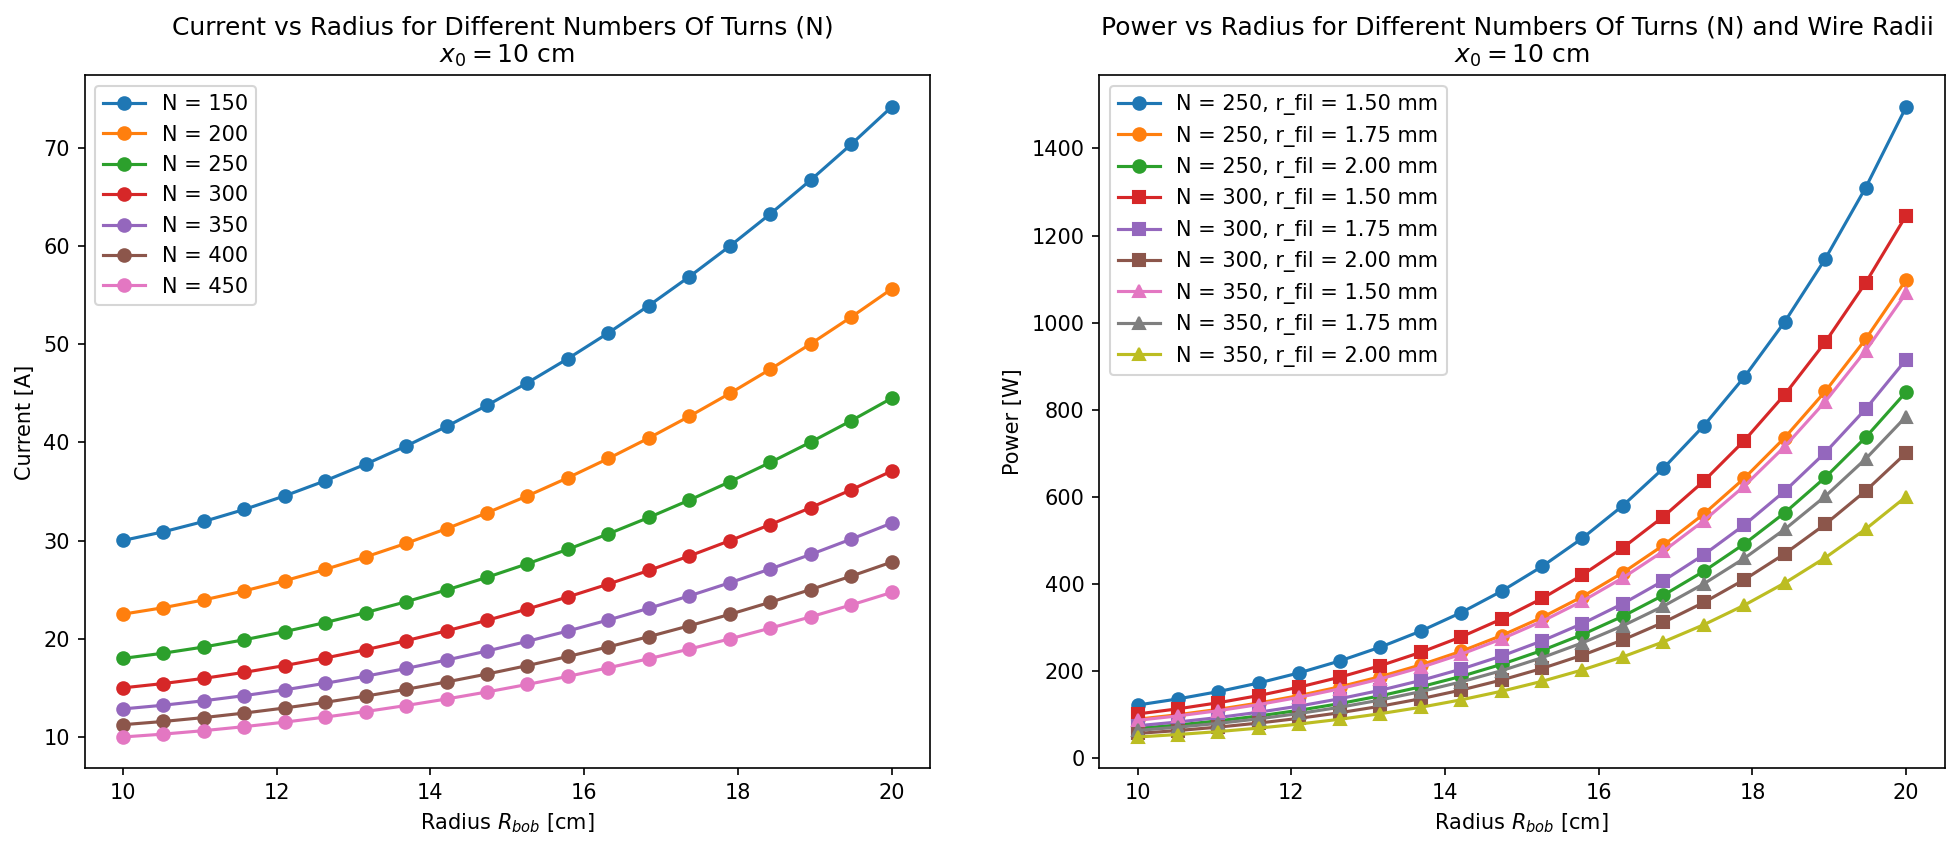

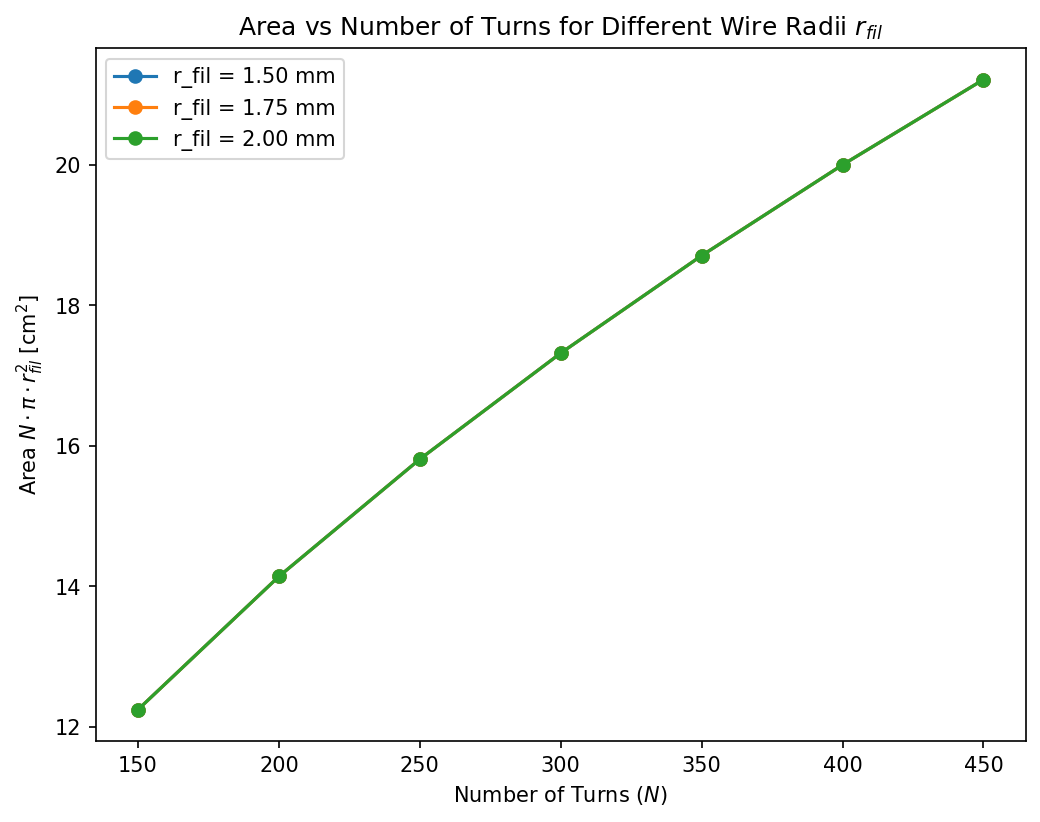

In [24]:
#%%
import numpy as np
TARGET = 30 #G/cm
# Define constants
mu_0 = 4 * np.pi * 1e-7

def current_func(R_bob, N, distance_between_coils=200e-3):
    # Ensure that broadcasting works correctly by using np.newaxis
    R_bob = np.asarray(R_bob)[:, np.newaxis]
    N = np.asarray(N)
    
    a = TARGET * ((R_bob**2 + (distance_between_coils/2)**2)**(5/2))
    b = (3 * mu_0 * R_bob**2 * distance_between_coils/2)
    # Vectorized formula for current
    return  1e-4*1e2*a/b/N

def Power_func(R_bob, N, r_fil, distance_between_coils=200e-3):
    # Ensure that broadcasting works correctly by using np.newaxis
    ro=1.7*1e-8 # ohm*m
    R_bob = np.asarray(R_bob)[:, np.newaxis]
    N = np.asarray(N)
    
    a = 2*np.pi*ro*R_bob*(1e-4*1e2*TARGET*(R_bob**2 + (distance_between_coils/2)**2)**(5/2))**2
    b = (np.pi*r_fil**2)*(3 * mu_0 * R_bob**2 * distance_between_coils/2)**2
    # Vectorized formula for current
    return  a/b/N

# Arrays for R_bob and N
R_bob_array = np.linspace(100e-3, 200e-3, 20)
N_array = np.arange(150, 500, 50)
#r_fil_array = np.arange(0.5e-3, 2e-3, 0.5e-3)
r_fil_array = np.linspace(1.5e-3, 2e-3, 3)

# Calculate the current for each combination of R_bob and N
#result = current_func(R_bob_array, 150).flatten()

# Create subplots for current and power
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=150)

for N in N_array:
    result = current_func(R_bob_array, N=N)

    ax1.plot(R_bob_array * 1e2, result.flatten(), 'o-', label=f'N = {N}')
ax1.set_xlabel('Radius $R_{bob}$ [cm]')
ax1.set_ylabel('Current [A]')
ax1.set_title('Current vs Radius for Different Numbers Of Turns (N) \n$x_0=10$ cm')
ax1.legend()

# Define a list of markers to use for each N
markers = ['o', 's', '^', 'D', 'x']  # Add more if you have more values of N
N_array = np.arange(250, 400, 50)
# Plot Power vs Radius for different N and multiple r_fil values
for idx, N in enumerate(N_array):
    marker = markers[idx % len(markers)]  # Use different marker for each N
    for r_fil in r_fil_array:
        result_power = Power_func(R_bob_array, N=N, r_fil=r_fil)
        ax2.plot(R_bob_array * 1e2, result_power.flatten(), marker + '-', 
                 label=f'N = {N}, r_fil = {r_fil*1e3:.2f} mm')
    
ax2.set_xlabel('Radius $R_{bob}$ [cm]')
ax2.set_ylabel('Power [W]')
ax2.set_title('Power vs Radius for Different Numbers Of Turns (N) and Wire Radii \n$x_0=10$ cm')
ax2.legend()


# Calculate the section of the coil
N_array = np.arange(150, 500, 50)
fig, ax3 = plt.subplots(figsize=(8, 6), dpi=150)
for r_fil in r_fil_array:
    area_array = []  # To store the area for each N
    for N in N_array:
        # Calculate N * pi * r_fil^2
        area = N * np.pi * r_fil**2 * 1e4
        area_array.append(area)  # Store the area
    
    # Plot the area vs N for the current r_fil
    ax3.plot(N_array, np.sqrt(N_array), 'o-', label=f'r_fil = {r_fil*1e3:.2f} mm')

# Set axis labels and title
ax3.set_xlabel('Number of Turns $(N)$')
ax3.set_ylabel('Area $N \\cdot \\pi \\cdot r_{fil}^2$ [cm$^2$]')
ax3.set_title('Area vs Number of Turns for Different Wire Radii $r_{fil}$')

# Add a legend
ax3.legend()


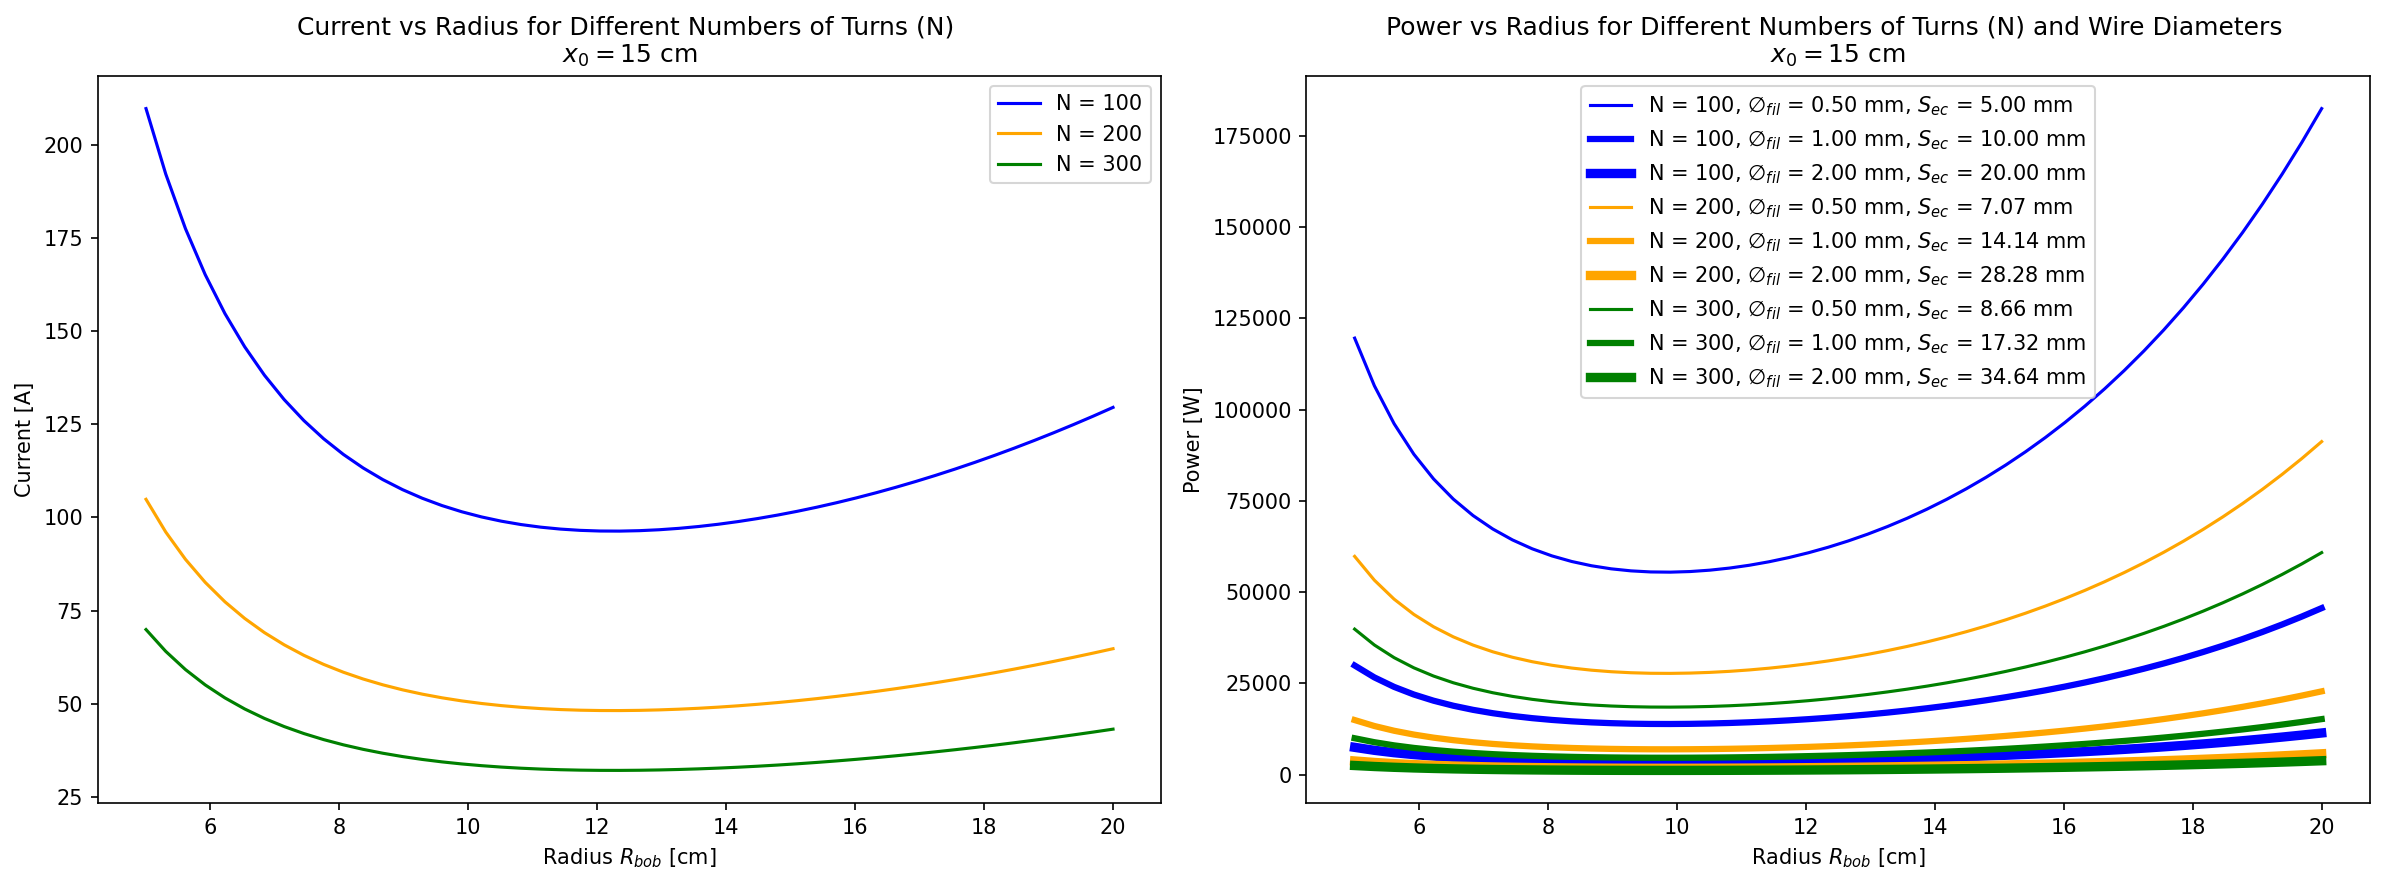

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
TARGET = 30  # G/cm
mu_0 = 4 * np.pi * 1e-7

def current_func(R_bob, N, distance_between_coils=300e-3):
    # Ensure that broadcasting works correctly by using np.newaxis
    R_bob = np.asarray(R_bob)[:, np.newaxis]
    N = np.asarray(N)
    
    a = TARGET * ((R_bob**2 + (distance_between_coils / 2)**2)**(5/2))
    b = (3 * mu_0 * R_bob**2 * distance_between_coils / 2)
    return 1e-4 * 1e2 * a / b / N

def Power_func(R_bob, N, r_fil, distance_between_coils=300e-3):
    # Ensure that broadcasting works correctly by using np.newaxis
    ro = 1.7 * 1e-8  # ohm*m
    R_bob = np.asarray(R_bob)[:, np.newaxis]
    N = np.asarray(N)
    
    a = 2 * np.pi * ro * R_bob * (1e-4 * 1e2 * TARGET * (R_bob**2 + (distance_between_coils / 2)**2)**(5/2))**2
    b = (np.pi * r_fil**2) * (3 * mu_0 * R_bob**2 * distance_between_coils / 2)**2
    return a / b / N

# Arrays for R_bob and N
R_bob_array = np.linspace(50e-3, 200e-3, 50)  # Radius array
N_array = [100, 200, 300]  # Number of turns for the first and second plot

# Specific r_fil values
r_fil_array = [0.5e-3 / 2, 1e-3 / 2, 2e-3 / 2]  # Wire radii (r_fil) in meters

# Predefined line widths for the three r_fil values
line_widths = [1.5, 3, 4.5]  # Preset line widths for each wire radius

# Predefined colors: blue, orange, and green
colors = ['blue', 'orange', 'green']

# Create subplots for current and power
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=150)

# Plot Current vs Radius for different N with consistent colors
for idx, N in enumerate(N_array):
    color = colors[idx]  # Use blue, orange, and green for N = 100, 200, 300
    result = current_func(R_bob_array, N=N)
    ax1.plot(R_bob_array * 1e2, result.flatten(), label=f'N = {N}', color=color)
ax1.set_xlabel('Radius $R_{bob}$ [cm]')
ax1.set_ylabel('Current [A]')
ax1.set_title('Current vs Radius for Different Numbers of Turns (N) \n$x_0=15$ cm')
ax1.legend()

# Plot Power vs Radius for different N and use preset line widths for different r_fil
for idx, N in enumerate(N_array):
    color = colors[idx]  # Use blue, orange, and green for N = 100, 200, 300
    for j, r_fil in enumerate(r_fil_array):
        # Calculate the diameter (2 * r_fil)
        diameter_fil = 2 * r_fil
        # Calculate S_ec = 2 * sqrt(N) * r_fil
        S_ec = 2 * np.sqrt(N) * r_fil
        result_power = Power_func(R_bob_array, N=N, r_fil=r_fil)
        ax2.plot(R_bob_array * 1e2, result_power.flatten(), '-', 
                 label=f'N = {N}, $\\varnothing_{{fil}}$ = {diameter_fil*1e3:.2f} mm, $S_{{ec}}$ = {S_ec*1e3:.2f} mm', 
                 linewidth=line_widths[j], color=color)  # Use predefined color

ax2.set_xlabel('Radius $R_{bob}$ [cm]')
ax2.set_ylabel('Power [W]')
ax2.set_title('Power vs Radius for Different Numbers of Turns (N) and Wire Diameters \n$x_0=15$ cm')
ax2.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show plots
plt.show()